# Rossman Store Sale

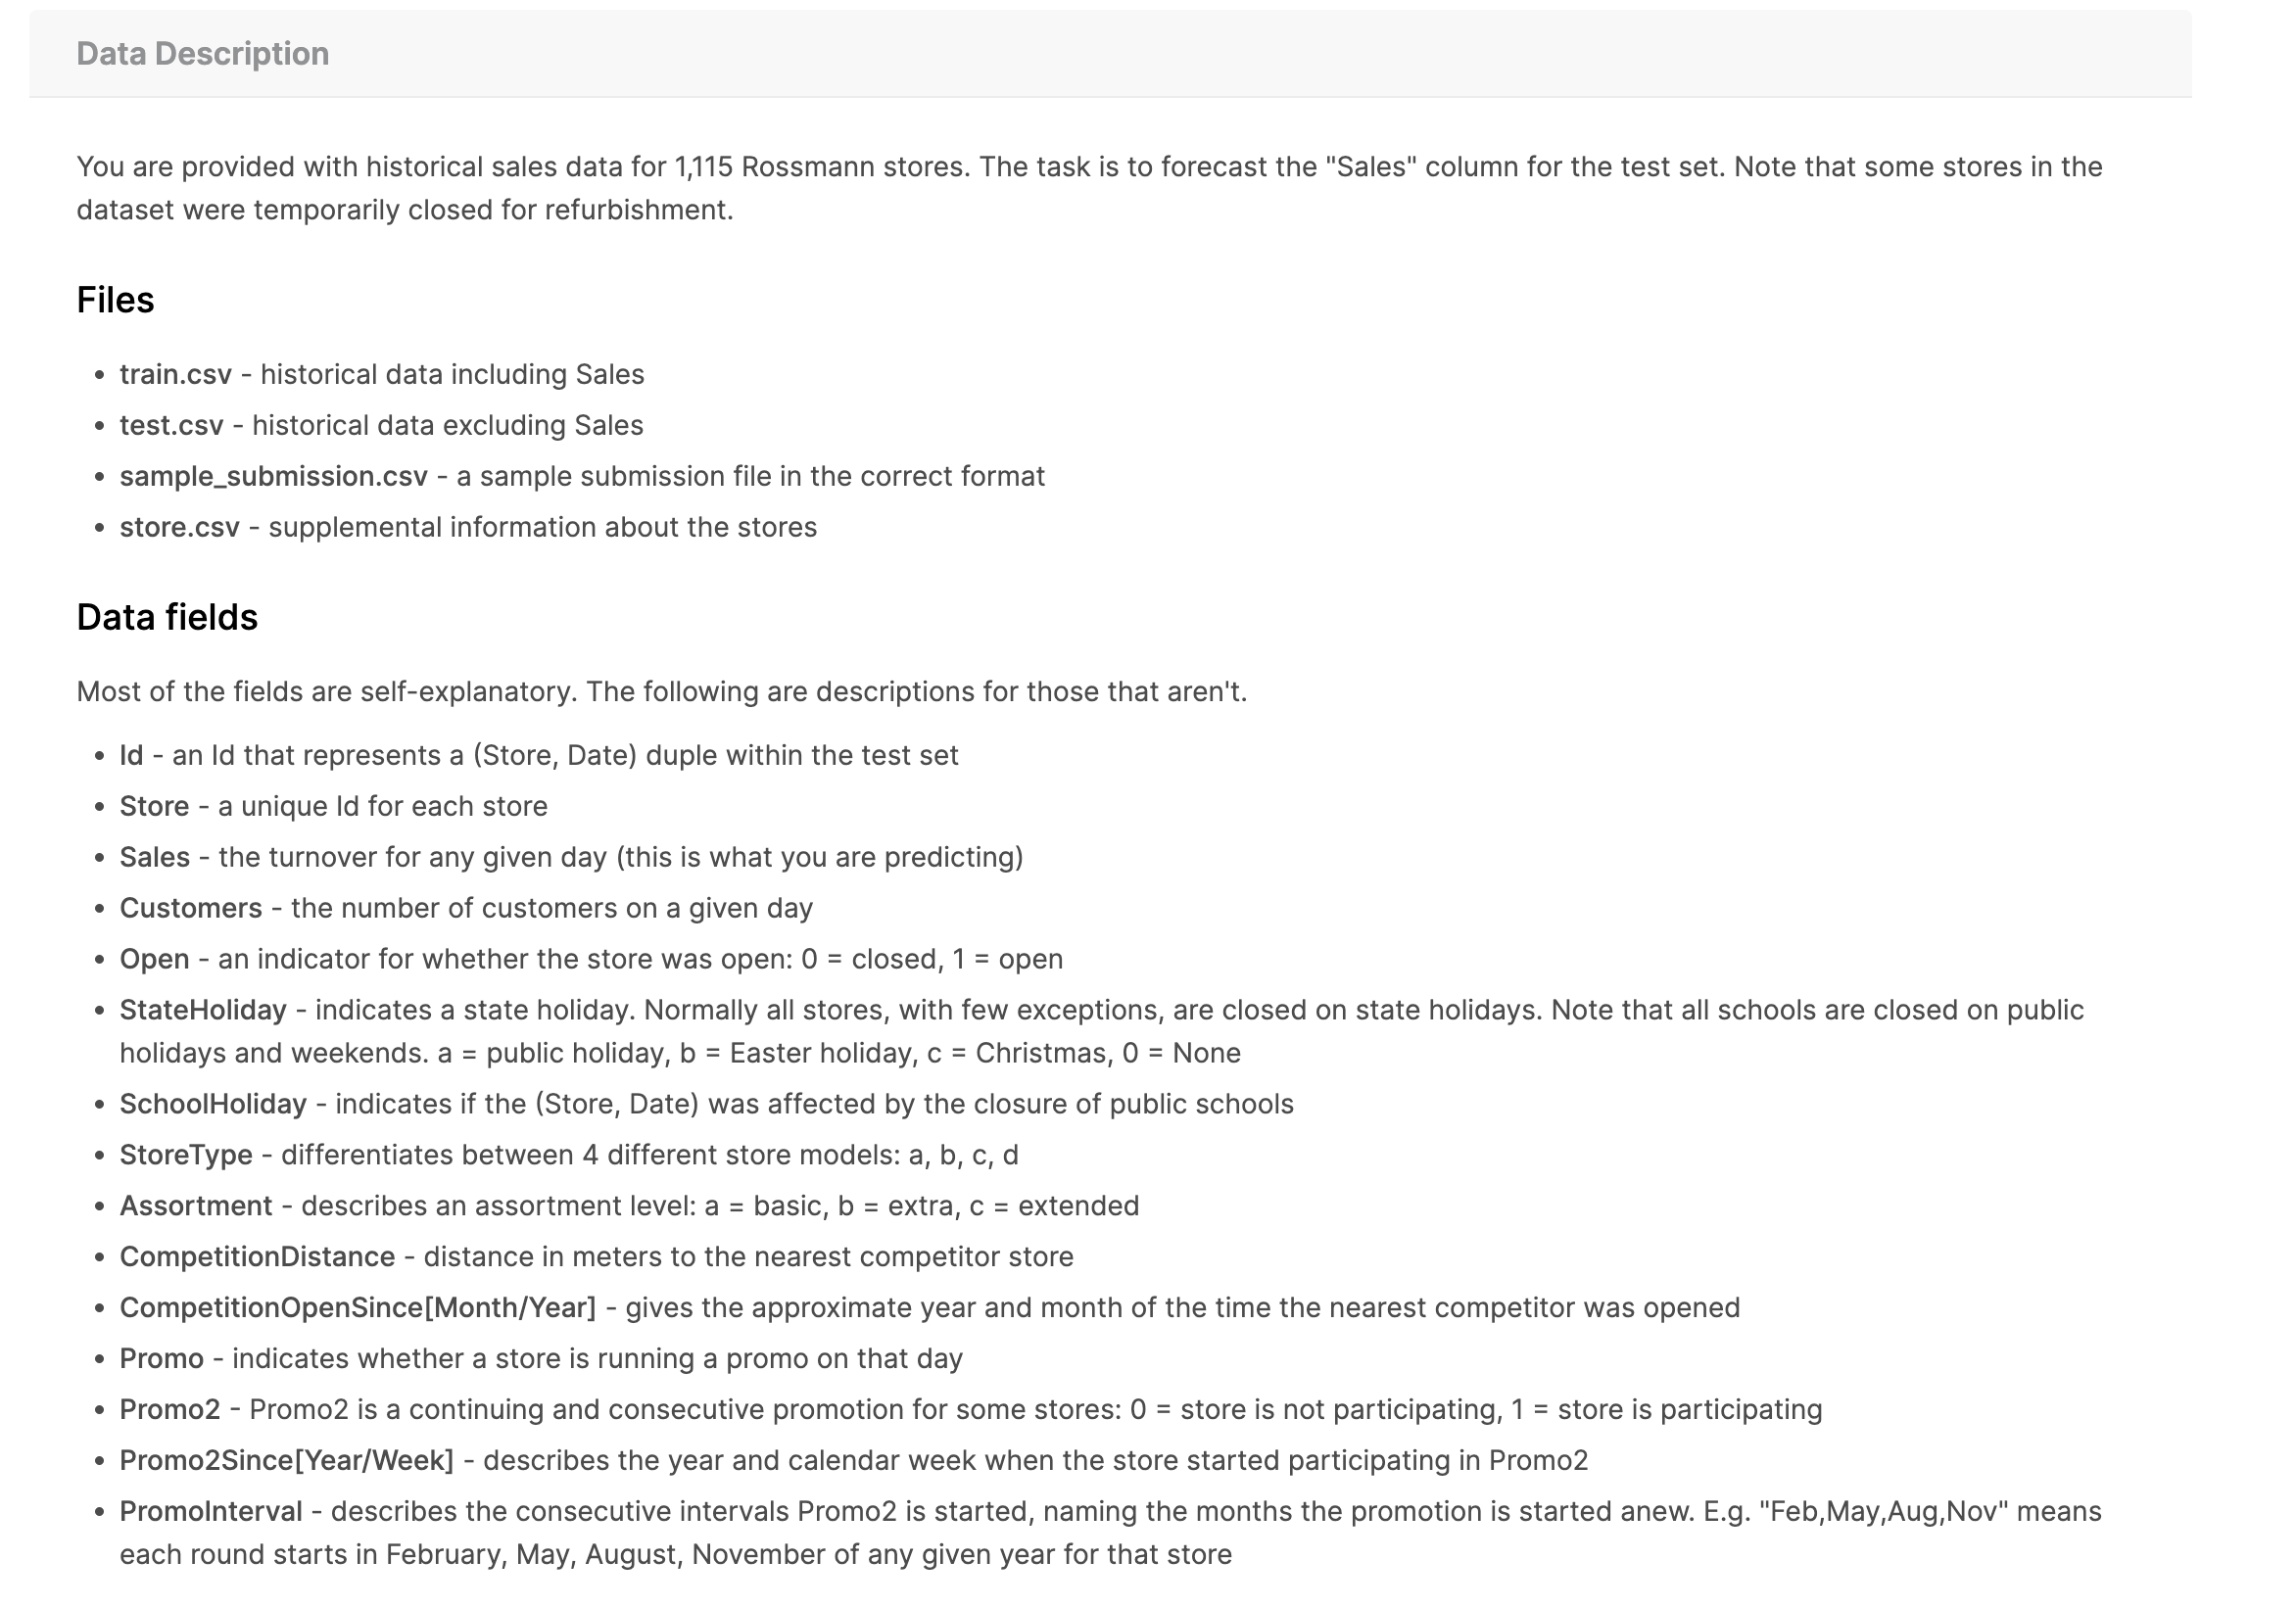

In [ ]:
!pip install xgboost  --upgrade --quiet

In [ ]:
!pip list | grep xgboost

In [1]:
from xgboost import XGBRegressor

In [2]:
import pandas as pd
import numpy as np
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 10)

In [271]:
ross_df = pd.read_csv("train.csv")
store_df = pd.read_csv("store.csv")
test_df = pd.read_csv("test.csv")
submission_df = pd.read_csv("sample_submission.csv")

/var/folders/77/506sgzjs15b84ns9yp8cp2rc0000gn/T/ipykernel_53772/964360254.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  ross_df = pd.read_csv("train.csv")


In [272]:
ross_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1


In [273]:
store_df

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [274]:
test_df

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0
...,...,...,...,...,...,...,...,...
41083,41084,1111,6,2015-08-01,1.0,0,0,0
41084,41085,1112,6,2015-08-01,1.0,0,0,0
41085,41086,1113,6,2015-08-01,1.0,0,0,0
41086,41087,1114,6,2015-08-01,1.0,0,0,0


In [275]:
submission_df

,Id,Sales
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
41083,41084,0
41084,41085,0
41085,41086,0
41086,41087,0


## Exploratory Data Analysis

## Data Preprocessing

### Merge Datasets

In [276]:
merged_df = ross_df.merge(store_df, how='left', on='Store')      # keep all rows on ross_df (daily sale)
merged_test_df = test_df.merge(store_df, how='left', on='Store') # keep all dates from test set for submission

In [277]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

### Add Features

#### Date

In [278]:
def split_date(df):
    df['Date'] = pd.to_datetime(df['Date'])    # convert the date column into datetime column
    df['Year'] = df.Date.dt.year               # then extract year, month, day, week
    df['Month'] = df.Date.dt.month
    df['Day'] = df.Date.dt.day
    df['WeekOfYear'] = df.Date.dt.isocalendar().week

In [279]:
split_date(merged_df)
split_date(merged_test_df)

In [280]:
merged_df.head(3)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015,7,31,31
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31


In [281]:
merged_df.tail(3)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN,2013,1,1,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN,2013,1,1,1
1017208,1115,2,2013-01-01,0,0,0,0,a,1,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec",2013,1,1,1


#### Open

- Remove the rows(days) where stores were not open

In [282]:
len(merged_df)

1017209

In [283]:
merged_df[merged_df["Open"]==0]["Sales"].value_counts()

0    172817
Name: Sales, dtype: int64

In [284]:
merged_df = merged_df[merged_df["Open"]==1].copy()

In [285]:
len(merged_df) # now the dataset shriks to 800,000 rows from 1 million row

844392

#### Competition

- We want to **make a new feature**. **How many months a compettitor is, 'CompetitionOpen'**
- Using column "Date" minus columns "CompettitionOpenSinceYear" and "CompetitionOpenSinceMonth"
- If a competitor occured after a particulare date of the store daily sale, we will exclude this data, 
- and replace with value 0
- If there's no competition, the value is NaN, we will also replace with 0

In [286]:
merged_df[['Date','CompetitionDistance', 'CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth']].sample(20, random_state=1)


,Date,CompetitionDistance,CompetitionOpenSinceYear,CompetitionOpenSinceMonth
380760,2014-07-30,520.0,2009.0,3.0
868349,2013-05-14,50.0,2015.0,6.0
51885,2015-06-15,290.0,2006.0,9.0
552309,2014-02-21,720.0,2004.0,11.0
151676,2015-03-17,4230.0,2014.0,12.0
...,...,...,...,...
883591,2013-04-30,1390.0,NaN,NaN
804595,2013-07-10,5290.0,2012.0,11.0
386865,2014-07-24,3230.0,2011.0,11.0
892468,2013-04-22,1700.0,2008.0,1.0


In [287]:
def comp_months(df):
    df['CompetitionOpen'] = 12 * (df.Year - df.CompetitionOpenSinceYear) + (df.Month - df.CompetitionOpenSinceMonth)
    
    df['CompetitionOpen'] = df['CompetitionOpen'].map(lambda x: 0 if x < 0 else x).fillna(0)
    
    # the 2nd line is when there's no competition store open yet, so we will replace this value with 0
    # also if the competition store will be open in the future year, which will make the 1st line calculation to be negative value,
    # we will replace it with 0 also
    

In [288]:
comp_months(merged_df)
comp_months(merged_test_df)

In [289]:
merged_df[['Date', 'CompetitionDistance', 'CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth', 'CompetitionOpen']].sample(20, random_state=1)


,Date,CompetitionDistance,CompetitionOpenSinceYear,CompetitionOpenSinceMonth,CompetitionOpen
380760,2014-07-30,520.0,2009.0,3.0,64.0
868349,2013-05-14,50.0,2015.0,6.0,0.0
51885,2015-06-15,290.0,2006.0,9.0,105.0
552309,2014-02-21,720.0,2004.0,11.0,111.0
151676,2015-03-17,4230.0,2014.0,12.0,3.0
...,...,...,...,...,...
883591,2013-04-30,1390.0,NaN,NaN,0.0
804595,2013-07-10,5290.0,2012.0,11.0,8.0
386865,2014-07-24,3230.0,2011.0,11.0,32.0
892468,2013-04-22,1700.0,2008.0,1.0,63.0


#### Promotion

- We want to **make new features** from promotion data
- 1. Is a store **is having a promotion running the current month**
- 2. If yes, **how long the promotion has been running, in months**


- "Promo2" indicates if a store is running a recurring promotion or not
- If it's 1, there will be values in "Promo2SincYear", "Promo2SinceWeek", "PromoInterval"
- If it's 0, these columns values will be NaN

In [290]:
merged_df[['Date', "Year",'WeekOfYear','Promo2', 'Promo2SinceYear', 'Promo2SinceWeek', 
           'PromoInterval']].sample(20, random_state=6)

,Date,Year,WeekOfYear,Promo2,Promo2SinceYear,Promo2SinceWeek,PromoInterval
142801,2015-03-25,2015,13,1,2009.0,37.0,"Jan,Apr,Jul,Oct"
325747,2014-09-27,2014,39,0,NaN,NaN,NaN
16745,2015-07-16,2015,29,1,2009.0,45.0,"Jan,Apr,Jul,Oct"
384307,2014-07-26,2014,30,1,2011.0,14.0,"Jan,Apr,Jul,Oct"
160243,2015-03-10,2015,11,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...
108371,2015-04-25,2015,17,0,NaN,NaN,NaN
77859,2015-05-23,2015,21,1,2012.0,1.0,"Jan,Apr,Jul,Oct"
880038,2013-05-04,2013,18,0,NaN,NaN,NaN
262454,2014-12-04,2014,49,0,NaN,NaN,NaN


- If "Promo2" is 1, we want to know if current month is running a promotion or not
- which, we can find from "PromoInterval"
- If the current month, is the same as "PromoInterval", the value in "IsPromo2Month" will be 1

In [291]:
def check_promo_month(row):
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',              
                 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    try:
        months = (row['PromoInterval'] or '').split(',')
        if row['Promo2Open'] and month2str[row['Month']] in months:
            return 1
        else:
            return 0
    except Exception:
        return 0

def promo_cols(df):
    # Months since Promo2 was open
    df['Promo2Open'] = 12 * (df.Year - df.Promo2SinceYear) +  (df.WeekOfYear - df.Promo2SinceWeek)*7/30.5
    df['Promo2Open'] = df['Promo2Open'].map(lambda x: 0 if x < 0 else x).fillna(0) * df['Promo2']
    # Whether a new round of promotions was started in the current month
    df['IsPromo2Month'] = df.apply(check_promo_month, axis=1) * df['Promo2']
    

In [292]:
promo_cols(merged_df)
promo_cols(merged_test_df)

In [293]:
merged_df[['Date', "Year",'WeekOfYear','Promo2', 'Promo2SinceYear', 'Promo2SinceWeek', 
                              'PromoInterval', 'Promo2Open', 'IsPromo2Month']].sample(20,random_state=6)
           

,Date,Year,WeekOfYear,Promo2,Promo2SinceYear,Promo2SinceWeek,PromoInterval,Promo2Open,IsPromo2Month
142801,2015-03-25,2015,13,1,2009.0,37.0,"Jan,Apr,Jul,Oct",66.491803,0
325747,2014-09-27,2014,39,0,NaN,NaN,NaN,0.000000,0
16745,2015-07-16,2015,29,1,2009.0,45.0,"Jan,Apr,Jul,Oct",68.327869,1
384307,2014-07-26,2014,30,1,2011.0,14.0,"Jan,Apr,Jul,Oct",39.672131,1
160243,2015-03-10,2015,11,0,NaN,NaN,NaN,0.000000,0
...,...,...,...,...,...,...,...,...,...
108371,2015-04-25,2015,17,0,NaN,NaN,NaN,0.000000,0
77859,2015-05-23,2015,21,1,2012.0,1.0,"Jan,Apr,Jul,Oct",40.590164,0
880038,2013-05-04,2013,18,0,NaN,NaN,NaN,0.000000,0
262454,2014-12-04,2014,49,0,NaN,NaN,NaN,0.000000,0


#### Input and Target Columns

In [294]:
merged_df.head(3)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,CompetitionOpen,Promo2Open,IsPromo2Month
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015,7,31,31,82.0,0.000000,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31,92.0,64.131148,1
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31,103.0,51.901639,1


In [295]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844392 entries, 0 to 1017190
Data columns (total 25 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      844392 non-null  int64         
 1   DayOfWeek                  844392 non-null  int64         
 2   Date                       844392 non-null  datetime64[ns]
 3   Sales                      844392 non-null  int64         
 4   Customers                  844392 non-null  int64         
 5   Open                       844392 non-null  int64         
 6   Promo                      844392 non-null  int64         
 7   StateHoliday               844392 non-null  object        
 8   SchoolHoliday              844392 non-null  int64         
 9   StoreType                  844392 non-null  object        
 10  Assortment                 844392 non-null  object        
 11  CompetitionDistance        842206 non-null  float64

In [296]:
merged_df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Year', 'Month', 'Day',
       'WeekOfYear', 'CompetitionOpen', 'Promo2Open', 'IsPromo2Month'],
      dtype='object')

- Columns will be used for training
- Store will be included, this model shouldn't be used to predict sales for other stores than stores in the model
- Drop "Date" because we already have "Day", "Month", "Year"
- Drop "Sales" because it's a target
- Drop "Customers" because when we use the model to predict sales at a future date, we don't know how many customers
we have
- Drop "Open" because we already drop rows that the stores are closed, so the model is only training on dates that stores are open

In [297]:
input_cols = ['Store', 'DayOfWeek', 'Day', 'Month', 'Year', 'WeekOfYear',
              'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
             'Promo','CompetitionDistance', 'CompetitionOpen', 'Promo2', 'Promo2Open', 'IsPromo2Month']
target_col = 'Sales'

- **Make copy**

In [814]:
inputs = merged_df[input_cols].copy()
targets = merged_df[target_col].copy()

In [815]:
inputs

,Store,DayOfWeek,Day,Month,Year,WeekOfYear,StateHoliday,SchoolHoliday,StoreType,Assortment,Promo,CompetitionDistance,CompetitionOpen,Promo2,Promo2Open,IsPromo2Month
0,1,5,31,7,2015,31,0,1,c,a,1,1270.0,82.0,0,0.000000,0
1,2,5,31,7,2015,31,0,1,a,a,1,570.0,92.0,1,64.131148,1
2,3,5,31,7,2015,31,0,1,a,a,1,14130.0,103.0,1,51.901639,1
3,4,5,31,7,2015,31,0,1,c,c,1,620.0,70.0,0,0.000000,0
4,5,5,31,7,2015,31,0,1,a,a,1,29910.0,3.0,0,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,2,1,1,2013,1,a,1,b,a,0,150.0,76.0,0,0.000000,0
1016827,733,2,1,1,2013,1,a,1,b,b,0,860.0,159.0,0,0.000000,0
1016863,769,2,1,1,2013,1,a,1,b,b,0,840.0,0.0,1,1.213115,1
1017042,948,2,1,1,2013,1,a,1,b,b,0,1430.0,0.0,0,0.000000,0


In [816]:
test_inputs = merged_test_df[input_cols].copy()

In [817]:
test_inputs

,Store,DayOfWeek,Day,Month,Year,WeekOfYear,StateHoliday,SchoolHoliday,StoreType,Assortment,Promo,CompetitionDistance,CompetitionOpen,Promo2,Promo2Open,IsPromo2Month
0,1,4,17,9,2015,38,0,0,c,a,1,1270.0,84.0,0,0.000000,0
1,3,4,17,9,2015,38,0,0,a,a,1,14130.0,105.0,1,53.508197,0
2,7,4,17,9,2015,38,0,0,a,c,1,24000.0,29.0,0,0.000000,0
3,8,4,17,9,2015,38,0,0,a,a,1,7520.0,11.0,0,0.000000,0
4,9,4,17,9,2015,38,0,0,a,c,1,2030.0,181.0,0,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41083,1111,6,1,8,2015,31,0,0,a,a,0,1900.0,14.0,1,24.000000,0
41084,1112,6,1,8,2015,31,0,0,c,c,0,1880.0,112.0,0,0.000000,0
41085,1113,6,1,8,2015,31,0,0,a,c,0,9260.0,0.0,0,0.000000,0
41086,1114,6,1,8,2015,31,0,0,a,c,0,870.0,0.0,0,0.000000,0


In [818]:
targets

0           5263
1           6064
2           8314
3          13995
4           4822
           ...  
1016776     3375
1016827    10765
1016863     5035
1017042     4491
1017190     5961
Name: Sales, Length: 844392, dtype: int64

- **numeric and categorical columns**

- Separate numerical and categorical columns
- Sometimes we can separate by using dtype = "object"
- Sometimes int can be categorical, so need to consider manually

In [819]:
def print_unique_col_values(df):
       for column in df:
            if df[column].dtypes=='object':
                print(column, df[column].unique()) 

In [820]:
print_unique_col_values(inputs)

StateHoliday ['0' 'a' 'b' 'c' 0]
StoreType ['c' 'a' 'd' 'b']
Assortment ['a' 'c' 'b']


- "DayOfWeek" and "Day" can be either numeric or categorical
- Here we treat "DayOfWeek" as categorical and assume that 
- Sales are not generally linearly correlated with "Monday"-"Sunday"
- If the model is decision tree, decision tree can work for both types 

In [821]:
numeric_cols = ['Store', 'Day', 'Month', 'Year', 'WeekOfYear' ,'SchoolHoliday', 'Promo', 
              'CompetitionDistance', 'CompetitionOpen', 'Promo2', 'Promo2Open', 'IsPromo2Month']
categorical_cols = ['DayOfWeek', 'StateHoliday', 'StoreType', 'Assortment']

#### Impute missing numerical data

In [822]:
inputs[numeric_cols].isna().sum()

Store                     0
Day                       0
Month                     0
Year                      0
WeekOfYear                0
                       ... 
CompetitionDistance    2186
CompetitionOpen           0
Promo2                    0
Promo2Open                0
IsPromo2Month             0
Length: 12, dtype: int64

- There are 2186 missing values in "CompetitionDistance"
- We shouldn't replace these rows with 0 or low value because
- that would mean the distance of the competition is very near, close to the store location
- So, we should replace these missing values with very high value to indicate that 
- the competitor distance is very very far away, which might not affect the sales of the store

In [823]:
test_inputs[numeric_cols].isna().sum()

Store                   0
Day                     0
Month                   0
Year                    0
WeekOfYear              0
                       ..
CompetitionDistance    96
CompetitionOpen         0
Promo2                  0
Promo2Open              0
IsPromo2Month           0
Length: 12, dtype: int64

- We will replace the NaN values with max distance times 2 to make the value higher

In [824]:
max_distance = inputs.CompetitionDistance.max()

In [825]:
max_distance 

75860.0

In [826]:
inputs['CompetitionDistance'].fillna(max_distance*2, inplace=True)
test_inputs['CompetitionDistance'].fillna(max_distance*2, inplace=True)

In [827]:
inputs['CompetitionDistance'].max()

151720.0

#### Scale Numeric Values

In [828]:
from sklearn.preprocessing import MinMaxScaler

In [829]:
len(inputs[numeric_cols].columns)

12

In [830]:
len(test_inputs[numeric_cols].columns)

12

In [831]:
inputs[numeric_cols].head(3)

,Store,Day,Month,Year,WeekOfYear,SchoolHoliday,Promo,CompetitionDistance,CompetitionOpen,Promo2,Promo2Open,IsPromo2Month
0,1,31,7,2015,31,1,1,1270.0,82.0,0,0.000000,0
1,2,31,7,2015,31,1,1,570.0,92.0,1,64.131148,1
2,3,31,7,2015,31,1,1,14130.0,103.0,1,51.901639,1


In [832]:
len(inputs.columns)

16

In [833]:
len(test_inputs.columns)

16

In [834]:
scaler = MinMaxScaler().fit(inputs[numeric_cols]) # only fit training set 

In [835]:
inputs[numeric_cols] = scaler.transform(inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

In [836]:
inputs[numeric_cols].head(3)

,Store,Day,Month,Year,WeekOfYear,SchoolHoliday,Promo,CompetitionDistance,CompetitionOpen,Promo2,Promo2Open,IsPromo2Month
0,0.000000,1.0,0.545455,1.0,0.588235,1.0,1.0,0.008240,0.059163,0.0,0.000000,0.0
1,0.000898,1.0,0.545455,1.0,0.588235,1.0,1.0,0.003626,0.066378,1.0,0.890710,1.0
2,0.001795,1.0,0.545455,1.0,0.588235,1.0,1.0,0.093013,0.074315,1.0,0.720856,1.0


In [837]:
len(inputs.columns)

16

In [838]:
len(test_inputs.columns)

16

In [839]:
inputs.columns == test_inputs.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

**Encoding Categorical Columns**

- We use OneHotEncoding (or pd.get_dummies()) because 
- we assume that these are not ordinal category

In [840]:
from sklearn.preprocessing import OneHotEncoder

In [841]:
inputs.head(3)

,Store,DayOfWeek,Day,Month,Year,WeekOfYear,StateHoliday,SchoolHoliday,StoreType,Assortment,Promo,CompetitionDistance,CompetitionOpen,Promo2,Promo2Open,IsPromo2Month
0,0.000000,5,1.0,0.545455,1.0,0.588235,0,1.0,c,a,1.0,0.008240,0.059163,0.0,0.000000,0.0
1,0.000898,5,1.0,0.545455,1.0,0.588235,0,1.0,a,a,1.0,0.003626,0.066378,1.0,0.890710,1.0
2,0.001795,5,1.0,0.545455,1.0,0.588235,0,1.0,a,a,1.0,0.093013,0.074315,1.0,0.720856,1.0


In [842]:
inputs[categorical_cols].head(3)

,DayOfWeek,StateHoliday,StoreType,Assortment
0,5,0,c,a
1,5,0,a,a
2,5,0,a,a


In [843]:
inputs["DayOfWeek"].info()

<class 'pandas.core.series.Series'>
Int64Index: 844392 entries, 0 to 1017190
Series name: DayOfWeek
Non-Null Count   Dtype
--------------   -----
844392 non-null  int64
dtypes: int64(1)
memory usage: 12.9 MB


In [844]:
test_inputs["DayOfWeek"].info()

<class 'pandas.core.series.Series'>
Int64Index: 41088 entries, 0 to 41087
Series name: DayOfWeek
Non-Null Count  Dtype
--------------  -----
41088 non-null  int64
dtypes: int64(1)
memory usage: 642.0 KB


In [845]:
inputs["DayOfWeek"].value_counts()

6    144058
2    143961
3    141936
5    138640
1    137560
4    134644
7      3593
Name: DayOfWeek, dtype: int64

In [846]:
test_inputs["DayOfWeek"].value_counts()

4    5992
3    5992
2    5992
1    5992
7    5992
6    5992
5    5136
Name: DayOfWeek, dtype: int64

In [847]:
inputs["DayOfWeek"].unique()

array([5, 4, 3, 2, 1, 7, 6])

In [848]:
test_inputs["DayOfWeek"].unique()

array([4, 3, 2, 1, 7, 6, 5])

In [849]:
inputs["StateHoliday"].unique()

array(['0', 'a', 'b', 'c', 0], dtype=object)

In [850]:
inputs["StoreType"].unique()

array(['c', 'a', 'd', 'b'], dtype=object)

In [851]:
test_inputs["StoreType"].unique()

array(['c', 'a', 'd', 'b'], dtype=object)

In [852]:
inputs["Assortment"].unique()

array(['a', 'c', 'b'], dtype=object)

In [853]:
test_inputs["Assortment"].unique()

array(['a', 'c', 'b'], dtype=object)

In [854]:
inputs["StateHoliday"].value_counts()

0    731342
0    112140
a       694
b       145
c        71
Name: StateHoliday, dtype: int64

In [855]:
test_inputs["StateHoliday"].value_counts()

0    40908
a      180
Name: StateHoliday, dtype: int64

In [856]:
test_inputs["StateHoliday"].unique()

array(['0', 'a'], dtype=object)

In [857]:
inputs["StateHoliday"]==0

0          False
1          False
2          False
3          False
4          False
           ...  
1016776    False
1016827    False
1016863    False
1017042    False
1017190    False
Name: StateHoliday, Length: 844392, dtype: bool

In [858]:
inputs["StateHoliday"]=='0'

0           True
1           True
2           True
3           True
4           True
           ...  
1016776    False
1016827    False
1016863    False
1017042    False
1017190    False
Name: StateHoliday, Length: 844392, dtype: bool

In [859]:
inputs[inputs["StateHoliday"]== 0] = '0'

In [860]:
inputs["StateHoliday"].value_counts()

0    843482
a       694
b       145
c        71
Name: StateHoliday, dtype: int64

- Now we will add encoded categorical columns 
- Now the columns will expand because of the categorical columns OneHotEncoding

In [861]:
[categorical_cols]

[['DayOfWeek', 'StateHoliday', 'StoreType', 'Assortment']]

In [862]:
inputs.head()

,Store,DayOfWeek,Day,Month,Year,WeekOfYear,StateHoliday,SchoolHoliday,StoreType,Assortment,Promo,CompetitionDistance,CompetitionOpen,Promo2,Promo2Open,IsPromo2Month
0,0.0,5,1.0,0.545455,1.0,0.588235,0,1.0,c,a,1.0,0.00824,0.059163,0.0,0.0,0.0
1,0.000898,5,1.0,0.545455,1.0,0.588235,0,1.0,a,a,1.0,0.003626,0.066378,1.0,0.89071,1.0
2,0.001795,5,1.0,0.545455,1.0,0.588235,0,1.0,a,a,1.0,0.093013,0.074315,1.0,0.720856,1.0
3,0.002693,5,1.0,0.545455,1.0,0.588235,0,1.0,c,c,1.0,0.003955,0.050505,0.0,0.0,0.0
4,0.003591,5,1.0,0.545455,1.0,0.588235,0,1.0,a,a,1.0,0.197034,0.002165,0.0,0.0,0.0


In [863]:
len(inputs.columns)

16

In [864]:
inputs = pd.concat([inputs, pd.get_dummies(inputs[categorical_cols])], axis=1)

In [865]:
inputs.head(3)

,Store,DayOfWeek,Day,Month,Year,WeekOfYear,StateHoliday,SchoolHoliday,StoreType,Assortment,Promo,CompetitionDistance,CompetitionOpen,Promo2,Promo2Open,IsPromo2Month,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7,DayOfWeek_0,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c,StoreType_0,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_0,Assortment_a,Assortment_b,Assortment_c
0,0.0,5,1.0,0.545455,1.0,0.588235,0,1.0,c,a,1.0,0.00824,0.059163,0.0,0.0,0.0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
1,0.000898,5,1.0,0.545455,1.0,0.588235,0,1.0,a,a,1.0,0.003626,0.066378,1.0,0.89071,1.0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0
2,0.001795,5,1.0,0.545455,1.0,0.588235,0,1.0,a,a,1.0,0.093013,0.074315,1.0,0.720856,1.0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0


In [866]:
len(inputs.columns)

37

- Now encoded test_inputs

In [916]:
test_inputs_copy = test_inputs.copy()

In [917]:
test_inputs_copy[categorical_cols].head(3)

,DayOfWeek,StateHoliday,StoreType,Assortment
0,4,0,c,a
1,4,0,a,a
2,4,0,a,c


- For unknown reason, "DayOfWeek" on test_inputs gives weird result

In [918]:
categorical_cols2 = ["StateHoliday", "StoreType", "Assortment"]

In [919]:
test_inputs_copy = pd.concat([test_inputs_copy, pd.get_dummies(test_inputs_copy[categorical_cols2])], axis=1)

In [920]:
test_inputs_copy.head(3)

,Store,DayOfWeek,Day,Month,Year,WeekOfYear,StateHoliday,SchoolHoliday,StoreType,Assortment,Promo,CompetitionDistance,CompetitionOpen,Promo2,Promo2Open,IsPromo2Month,StateHoliday_0,StateHoliday_a,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c
0,0.000000,4,0.533333,0.727273,1.0,0.72549,0,0.0,c,a,1.0,0.008240,0.060606,0.0,0.000000,0.0,1,0,0,0,1,0,1,0,0
1,0.001795,4,0.533333,0.727273,1.0,0.72549,0,0.0,a,a,1.0,0.093013,0.075758,1.0,0.743169,0.0,1,0,1,0,0,0,1,0,0
2,0.005386,4,0.533333,0.727273,1.0,0.72549,0,0.0,a,c,1.0,0.158075,0.020924,0.0,0.000000,0.0,1,0,1,0,0,0,0,0,1


In [921]:
len(test_inputs_copy.columns)

25

In [922]:
categorical_cols3 = ["DayOfWeek"]

In [923]:
test_inputs_copy = pd.concat([test_inputs_copy, pd.get_dummies(test_inputs_copy["DayOfWeek"])], axis=1)

In [924]:
test_inputs_copy.head(3)

,Store,DayOfWeek,Day,Month,Year,WeekOfYear,StateHoliday,SchoolHoliday,StoreType,Assortment,Promo,CompetitionDistance,CompetitionOpen,Promo2,Promo2Open,IsPromo2Month,StateHoliday_0,StateHoliday_a,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,1,2,3,4,5,6,7
0,0.000000,4,0.533333,0.727273,1.0,0.72549,0,0.0,c,a,1.0,0.008240,0.060606,0.0,0.000000,0.0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0
1,0.001795,4,0.533333,0.727273,1.0,0.72549,0,0.0,a,a,1.0,0.093013,0.075758,1.0,0.743169,0.0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0
2,0.005386,4,0.533333,0.727273,1.0,0.72549,0,0.0,a,c,1.0,0.158075,0.020924,0.0,0.000000,0.0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0


In [925]:
day_wanted_cols=["DayOfWeek_0","DayOfWeek_1","DayOfWeek_2", "DayOfWeek_3", "DayOfWeek_4", "DayOfWeek_5", "DayOfWeek_6"]


In [928]:
day_2rename_cols = [1,2,3,4,5,6,7]

In [929]:
test_inputs_copy[day_wanted_cols] = test_inputs_copy[day_2rename_cols]

In [935]:
test_inputs_copy

,Store,DayOfWeek,Day,Month,Year,WeekOfYear,StateHoliday,SchoolHoliday,StoreType,Assortment,Promo,CompetitionDistance,CompetitionOpen,Promo2,Promo2Open,IsPromo2Month,StateHoliday_0,StateHoliday_a,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,1,2,3,4,5,6,7,DayOfWeek_0,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6
0,0.000000,4,0.533333,0.727273,1.0,0.725490,0,0.0,c,a,1.0,0.008240,0.060606,0.0,0.000000,0.0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
1,0.001795,4,0.533333,0.727273,1.0,0.725490,0,0.0,a,a,1.0,0.093013,0.075758,1.0,0.743169,0.0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
2,0.005386,4,0.533333,0.727273,1.0,0.725490,0,0.0,a,c,1.0,0.158075,0.020924,0.0,0.000000,0.0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0
3,0.006284,4,0.533333,0.727273,1.0,0.725490,0,0.0,a,a,1.0,0.049440,0.007937,0.0,0.000000,0.0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
4,0.007181,4,0.533333,0.727273,1.0,0.725490,0,0.0,a,c,1.0,0.013250,0.130592,0.0,0.000000,0.0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41083,0.996409,6,0.000000,0.636364,1.0,0.588235,0,0.0,a,a,0.0,0.012393,0.010101,1.0,0.333333,0.0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
41084,0.997307,6,0.000000,0.636364,1.0,0.588235,0,0.0,c,c,0.0,0.012261,0.080808,0.0,0.000000,0.0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0
41085,0.998205,6,0.000000,0.636364,1.0,0.588235,0,0.0,a,c,0.0,0.060910,0.000000,0.0,0.000000,0.0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0
41086,0.999102,6,0.000000,0.636364,1.0,0.588235,0,0.0,a,c,0.0,0.005603,0.000000,0.0,0.000000,0.0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0


In [936]:
test_inputs = test_inputs_copy.copy()

- The encoded columns in test_inputs are less than inputs because
- StateHoliday_0 in test_inputs has only 1 column, while in inputs has 2 columns
- StateHoliday in test_inputs has only StateHoliday_a, while inputs has b and c


- Now we can drop un-encoded categorical columns

In [937]:
inputs.head(3)

,Store,DayOfWeek,Day,Month,Year,WeekOfYear,StateHoliday,SchoolHoliday,StoreType,Assortment,Promo,CompetitionDistance,CompetitionOpen,Promo2,Promo2Open,IsPromo2Month,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7,DayOfWeek_0,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c,StoreType_0,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_0,Assortment_a,Assortment_b,Assortment_c
0,0.0,5,1.0,0.545455,1.0,0.588235,0,1.0,c,a,1.0,0.00824,0.059163,0.0,0.0,0.0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
1,0.000898,5,1.0,0.545455,1.0,0.588235,0,1.0,a,a,1.0,0.003626,0.066378,1.0,0.89071,1.0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0
2,0.001795,5,1.0,0.545455,1.0,0.588235,0,1.0,a,a,1.0,0.093013,0.074315,1.0,0.720856,1.0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0


In [938]:
inputs.head(3)

,Store,DayOfWeek,Day,Month,Year,WeekOfYear,StateHoliday,SchoolHoliday,StoreType,Assortment,Promo,CompetitionDistance,CompetitionOpen,Promo2,Promo2Open,IsPromo2Month,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7,DayOfWeek_0,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c,StoreType_0,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_0,Assortment_a,Assortment_b,Assortment_c
0,0.0,5,1.0,0.545455,1.0,0.588235,0,1.0,c,a,1.0,0.00824,0.059163,0.0,0.0,0.0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
1,0.000898,5,1.0,0.545455,1.0,0.588235,0,1.0,a,a,1.0,0.003626,0.066378,1.0,0.89071,1.0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0
2,0.001795,5,1.0,0.545455,1.0,0.588235,0,1.0,a,a,1.0,0.093013,0.074315,1.0,0.720856,1.0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0


In [939]:
inputs.drop(categorical_cols, axis=1, inplace=True)

In [940]:
inputs.head(3)

,Store,Day,Month,Year,WeekOfYear,SchoolHoliday,Promo,CompetitionDistance,CompetitionOpen,Promo2,Promo2Open,IsPromo2Month,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7,DayOfWeek_0,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c,StoreType_0,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_0,Assortment_a,Assortment_b,Assortment_c
0,0.0,1.0,0.545455,1.0,0.588235,1.0,1.0,0.00824,0.059163,0.0,0.0,0.0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
1,0.000898,1.0,0.545455,1.0,0.588235,1.0,1.0,0.003626,0.066378,1.0,0.89071,1.0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0
2,0.001795,1.0,0.545455,1.0,0.588235,1.0,1.0,0.093013,0.074315,1.0,0.720856,1.0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0


In [941]:
len(inputs.columns)

33

In [ ]:
test_inputs.drop(categorical_cols, axis=1, inplace=True)

In [947]:
test_inputs.head(3)

,Store,Day,Month,Year,WeekOfYear,SchoolHoliday,Promo,CompetitionDistance,CompetitionOpen,Promo2,Promo2Open,IsPromo2Month,StateHoliday_0,StateHoliday_a,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,DayOfWeek_0,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6
0,0.000000,0.533333,0.727273,1.0,0.72549,0.0,1.0,0.008240,0.060606,0.0,0.000000,0.0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0
1,0.001795,0.533333,0.727273,1.0,0.72549,0.0,1.0,0.093013,0.075758,1.0,0.743169,0.0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0
2,0.005386,0.533333,0.727273,1.0,0.72549,0.0,1.0,0.158075,0.020924,0.0,0.000000,0.0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0


In [948]:
test_inputs.head()

,Store,Day,Month,Year,WeekOfYear,SchoolHoliday,Promo,CompetitionDistance,CompetitionOpen,Promo2,Promo2Open,IsPromo2Month,StateHoliday_0,StateHoliday_a,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,DayOfWeek_0,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6
0,0.000000,0.533333,0.727273,1.0,0.72549,0.0,1.0,0.008240,0.060606,0.0,0.000000,0.0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0
1,0.001795,0.533333,0.727273,1.0,0.72549,0.0,1.0,0.093013,0.075758,1.0,0.743169,0.0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0
2,0.005386,0.533333,0.727273,1.0,0.72549,0.0,1.0,0.158075,0.020924,0.0,0.000000,0.0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0
3,0.006284,0.533333,0.727273,1.0,0.72549,0.0,1.0,0.049440,0.007937,0.0,0.000000,0.0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0
4,0.007181,0.533333,0.727273,1.0,0.72549,0.0,1.0,0.013250,0.130592,0.0,0.000000,0.0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0


In [949]:
len(test_inputs.columns)

28

- Let's make a copy of the complete dataset

In [950]:
X = inputs[:]
X_test = test_inputs[:]

In [951]:
X

,Store,Day,Month,Year,WeekOfYear,SchoolHoliday,Promo,CompetitionDistance,CompetitionOpen,Promo2,Promo2Open,IsPromo2Month,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7,DayOfWeek_0,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c,StoreType_0,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_0,Assortment_a,Assortment_b,Assortment_c
0,0.0,1.0,0.545455,1.0,0.588235,1.0,1.0,0.00824,0.059163,0.0,0.0,0.0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
1,0.000898,1.0,0.545455,1.0,0.588235,1.0,1.0,0.003626,0.066378,1.0,0.89071,1.0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0
2,0.001795,1.0,0.545455,1.0,0.588235,1.0,1.0,0.093013,0.074315,1.0,0.720856,1.0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0
3,0.002693,1.0,0.545455,1.0,0.588235,1.0,1.0,0.003955,0.050505,0.0,0.0,0.0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
4,0.003591,1.0,0.545455,1.0,0.588235,1.0,1.0,0.197034,0.002165,0.0,0.0,0.0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,0.611311,0.0,0.0,0.0,0.0,1.0,0.0,0.000857,0.054834,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0
1016827,0.657092,0.0,0.0,0.0,0.0,1.0,0.0,0.005537,0.114719,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
1016863,0.689408,0.0,0.0,0.0,0.0,1.0,0.0,0.005405,0.0,1.0,0.016849,1.0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
1017042,0.85009,0.0,0.0,0.0,0.0,1.0,0.0,0.009295,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0


In [952]:
X_test

,Store,Day,Month,Year,WeekOfYear,SchoolHoliday,Promo,CompetitionDistance,CompetitionOpen,Promo2,Promo2Open,IsPromo2Month,StateHoliday_0,StateHoliday_a,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,DayOfWeek_0,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6
0,0.000000,0.533333,0.727273,1.0,0.725490,0.0,1.0,0.008240,0.060606,0.0,0.000000,0.0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0
1,0.001795,0.533333,0.727273,1.0,0.725490,0.0,1.0,0.093013,0.075758,1.0,0.743169,0.0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0
2,0.005386,0.533333,0.727273,1.0,0.725490,0.0,1.0,0.158075,0.020924,0.0,0.000000,0.0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0
3,0.006284,0.533333,0.727273,1.0,0.725490,0.0,1.0,0.049440,0.007937,0.0,0.000000,0.0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0
4,0.007181,0.533333,0.727273,1.0,0.725490,0.0,1.0,0.013250,0.130592,0.0,0.000000,0.0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41083,0.996409,0.000000,0.636364,1.0,0.588235,0.0,0.0,0.012393,0.010101,1.0,0.333333,0.0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0
41084,0.997307,0.000000,0.636364,1.0,0.588235,0.0,0.0,0.012261,0.080808,0.0,0.000000,0.0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0
41085,0.998205,0.000000,0.636364,1.0,0.588235,0.0,0.0,0.060910,0.000000,0.0,0.000000,0.0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0
41086,0.999102,0.000000,0.636364,1.0,0.588235,0.0,0.0,0.005603,0.000000,0.0,0.000000,0.0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0


## Model Prediction